In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [4]:
data = pd.read_csv('/Users/sudaisamani/Downloads/QVI_data.csv')
print(data.info())
print(data.head())
print(data.describe())
# Convert the DATE column to datetime format
# Create a YEARMONTH column in the format YYYYMM
data['DATE'] = pd.to_datetime(data['DATE'])
data['Year_Month'] = data['DATE'].dt.to_period('M')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB
None
   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-0

In [10]:
# Grouping by STORE_NBR and Year_Month
grouped_data = data.groupby(["STORE_NBR", "Year_Month"])

# Calculate the metrics
tot_sales = grouped_data.TOT_SALES.sum()
n_cust = grouped_data.LYLTY_CARD_NBR.nunique()
ntrans_percust = grouped_data.TXN_ID.size() / n_cust
nchips_pertrans = grouped_data.PROD_QTY.sum() / grouped_data.TXN_ID.size()
avg_priceperunit = tot_sales / grouped_data.PROD_QTY.sum()

# Put the metrics together in an array
metric_arrays = [tot_sales, n_cust, ntrans_percust, nchips_pertrans, avg_priceperunit]

# Create the metrics table from the array
metrics_data = pd.concat(metric_arrays, axis=1)

# Assign column labels
metrics_data.columns = ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit']

# Reset index to make STORE_NBR and Year_Month as columns
metrics_data = metrics_data.reset_index()

# Check the resulting metrics DataFrame
print(metrics_data)

      STORE_NBR Year_Month  tot_sales  n_cust  ntrans_percust  \
0             1    2018-07      206.9      49        1.061224   
1             1    2018-08      176.1      42        1.023810   
2             1    2018-09      278.8      59        1.050847   
3             1    2018-10      188.1      44        1.022727   
4             1    2018-11      192.6      46        1.021739   
...         ...        ...        ...     ...             ...   
3164        272    2019-02      395.5      45        1.066667   
3165        272    2019-03      442.3      50        1.060000   
3166        272    2019-04      445.1      54        1.037037   
3167        272    2019-05      314.6      34        1.176471   
3168        272    2019-06      312.1      34        1.088235   

      nchips_pertrans  avg_priceperunit  
0            1.192308          3.337097  
1            1.255814          3.261111  
2            1.209677          3.717333  
3            1.288889          3.243103  
4        

In [24]:
def calc_corr(trial, metric_col, input_table):
    trial_vals = input_table[input_table["STORE_NBR"] == trial].set_index("Year_Month")[metric_col]
    control_stores = input_table["STORE_NBR"].unique()
    control_stores = control_stores[control_stores != trial]

    corr_table = pd.DataFrame(columns=["Year_Month", "trial_store", "control_store", "correlation"])

    for control in control_stores:
        control_vals = input_table[input_table["STORE_NBR"] == control].set_index("Year_Month")[metric_col]

        # Align time periods (drop missing)
        aligned = pd.concat([trial_vals, control_vals], axis=1).dropna()
        if len(aligned) < 2:
            continue  # Skip if not enough data

        corr = aligned.iloc[:, 0].corr(aligned.iloc[:, 1])
        if pd.isna(corr):
            continue  # Skip if still NaN

        temp_df = pd.DataFrame({
            "Year_Month": aligned.index,
            "trial_store": trial,
            "control_store": control,
            "correlation": [corr] * len(aligned)
        })

        corr_table = pd.concat([corr_table, temp_df], ignore_index=True)

    return corr_table

In [22]:
# Run the function for each trial store and metric column
trial_stores = [77, 86, 88]
metric_cols = ["tot_sales", "n_cust", "ntrans_percust", "nchips_pertrans", "avg_priceperunit"]

corr_table = pd.concat([
    calc_corr(trial, metric_col, metrics_data)
    for trial in trial_stores
    for metric_col in metric_cols
])

# Display result
print(corr_table.head())

/var/folders/97/15lnvm890czc6jsm2_ws3vfm0000gn/T/ipykernel_12563/2620616177.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, temp_df], ignore_index=True)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid

  Year_Month trial_store control_store  correlation
0    2018-07          77             1     0.064391
1    2018-08          77             1     0.064391
2    2018-09          77             1     0.064391
3    2018-10          77             1     0.064391
4    2018-11          77             1     0.064391


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
def calc_magdist(trial, metric_cols, input_table):
    trial_stores = [77, 86, 88]
    control_stores = input_table[~input_table["STORE_NBR"].isin(trial_stores)]["STORE_NBR"].unique()
    dist_table = pd.DataFrame()

    for control in control_stores:
        dist_row = pd.DataFrame()

        for metric_col in metric_cols:
            # Get metric time series for trial and control
            trial_vals = input_table[input_table["STORE_NBR"] == trial].set_index("Year_Month")[metric_col]
            control_vals = input_table[input_table["STORE_NBR"] == control].set_index("Year_Month")[metric_col]

            # Align periods and compute absolute distance
            aligned = pd.concat([trial_vals, control_vals], axis=1).dropna()
            if aligned.empty:
                continue

            dist = abs(aligned.iloc[:, 0] - aligned.iloc[:, 1])
            dist_row[metric_col] = dist.values

        if dist_row.empty:
            continue

        # Add metadata
        dist_row.insert(0, 'YEARMONTH', aligned.index)
        dist_row.insert(1, 'trial_store', trial)
        dist_row.insert(2, 'control_store', control)
        dist_table = pd.concat([dist_table, dist_row], ignore_index=True)

    # Normalize distances: 1 - scaled difference (for similarity)
    for metric_col in metric_cols:
        dist_table[metric_col] = dist_table.groupby(['trial_store', 'YEARMONTH'])[metric_col].transform(
            lambda x: 1 - (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 1
        )

    # Compute average similarity (magnitude score)
    dist_table['mag_measure'] = dist_table[metric_cols].mean(axis=1)

    return dist_table


# Example usage
trial_stores = [77, 86, 88]
metric_cols = ["tot_sales", "n_cust", "ntrans_percust", "nchips_pertrans", "avg_priceperunit"]

dist_table = pd.concat([calc_magdist(trial, metric_cols, metrics_data) for trial in trial_stores], ignore_index=True)
print(dist_table.head())

  YEARMONTH  trial_store  control_store  tot_sales    n_cust  ntrans_percust  \
0   2018-07           77              1   0.935803  0.978947        0.954763   
1   2018-08           77              1   0.928950  0.943182        0.993245   
2   2018-09           77              1   0.958560  0.817204        0.991707   
3   2018-10           77              1   0.992431  0.931373        0.989465   
4   2018-11           77              1   0.961882  0.950000        0.849700   

   nchips_pertrans  avg_priceperunit  mag_measure  
0         0.370656          0.834235     0.814881  
1         0.554902          0.867881     0.857632  
2         0.359447          0.689527     0.763289  
3         0.889409          0.541765     0.868888  
4         0.407875          0.779259     0.789743  


In [31]:
# Step 1: Calculate correlation for each trial-control pair (per month)
def compute_correlation_by_pair(dist_df, metric_col='tot_sales'):
    corr_list = []
    for (trial, control), group in dist_df.groupby(['trial_store', 'control_store']):
        if group[metric_col].isnull().any() or group['mag_measure'].isnull().any():
            continue  # Skip if any missing data
        corr = group[metric_col].corr(group['mag_measure'])
        corr_list.append({
            'trial_store': trial,
            'control_store': control,
            'correlation': corr
        })
    return pd.DataFrame(corr_list)

# Step 2: Apply function and merge back
corr_scores = compute_correlation_by_pair(dist_table)
dist_table = dist_table.merge(corr_scores, on=['trial_store', 'control_store'], how='left')

# Step 3: Compute overall score (as in Quantium example)
dist_table['scores'] = dist_table['correlation'] * dist_table['mag_measure']

# Step 4: Function to display top candidates for a trial store
def display_trial_store(trial, dist_table):
    trial_data = dist_table[dist_table["trial_store"] == trial]
    summary = (
        trial_data.groupby('control_store')[['correlation', 'mag_measure', 'scores']]
        .mean()
        .sort_values(by='scores', ascending=False)
    )
    return summary

# ✅ Examples
print("Trial store: 77")
print(display_trial_store(77, dist_table).head())

print("\nTrial store: 86")
print(display_trial_store(86, dist_table).head())

print("\nTrial store: 88")
print(display_trial_store(88, dist_table).head())

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Trial store: 77
               correlation  mag_measure    scores
control_store                                    
9                 0.861079     0.856151  0.737214
18                0.755736     0.898492  0.679022
195               0.682653     0.886122  0.604914
17                0.821384     0.717469  0.589317
12                0.853654     0.688005  0.587318

Trial store: 86
               correlation  mag_measure    scores
control_store                                    
122               0.922998     0.917033  0.846420
144               0.949983     0.884135  0.839913
94                0.924257     0.895707  0.827863
28                0.910750     0.897802  0.817673
63                0.914929     0.875565  0.801080

Trial store: 88
               correlation  mag_measure    scores
control_store                                    
237               0.906302     0.924080  0.837495
58                0.895337     0.911741  0.816315
49                0.934455     0.869075  0.812112


In [33]:
def similarity_score(trial_data, control_data):
    # Align by YEARMONTH to ensure fair correlation
    merged = pd.merge(
        trial_data[['YEARMONTH', 'tot_sales', 'n_cust']],
        control_data[['YEARMONTH', 'tot_sales', 'n_cust']],
        on='YEARMONTH',
        suffixes=('_trial', '_control')
    ).dropna()

    if len(merged) < 2:
        return np.nan  # Not enough data to compute correlation

    # Calculate correlation of sales and customers
    sales_corr = merged['tot_sales_trial'].corr(merged['tot_sales_control'])
    cust_corr = merged['n_cust_trial'].corr(merged['n_cust_control'])

    if pd.isna(sales_corr) or pd.isna(cust_corr):
        return np.nan

    return sales_corr + cust_corr

In [35]:
def find_best_control_stores(trial_store, dist_table):
    trial_data = dist_table[dist_table['trial_store'] == trial_store]
    control_store_similarities = []

    for control_store in dist_table['control_store'].unique():
        control_data = dist_table[dist_table['control_store'] == control_store]
        
        score = similarity_score(trial_data, control_data)
        if not pd.isna(score):
            control_store_similarities.append((control_store, score))

    # Sort descending by similarity score
    control_store_similarities.sort(key=lambda x: x[1], reverse=True)
    return control_store_similarities

In [37]:
best_controls_77 = find_best_control_stores(77, dist_table)
print("Best control stores for trial store 77:")
for control, score in best_controls_77[:5]:
    print(f"Control Store: {control}, Similarity Score: {score:.4f}")

Best control stores for trial store 77:
Control Store: 270, Similarity Score: 0.0228
Control Store: 94, Similarity Score: 0.0219
Control Store: 23, Similarity Score: 0.0218
Control Store: 123, Similarity Score: 0.0214
Control Store: 212, Similarity Score: 0.0198


/var/folders/97/15lnvm890czc6jsm2_ws3vfm0000gn/T/ipykernel_12563/2674656263.py:18: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


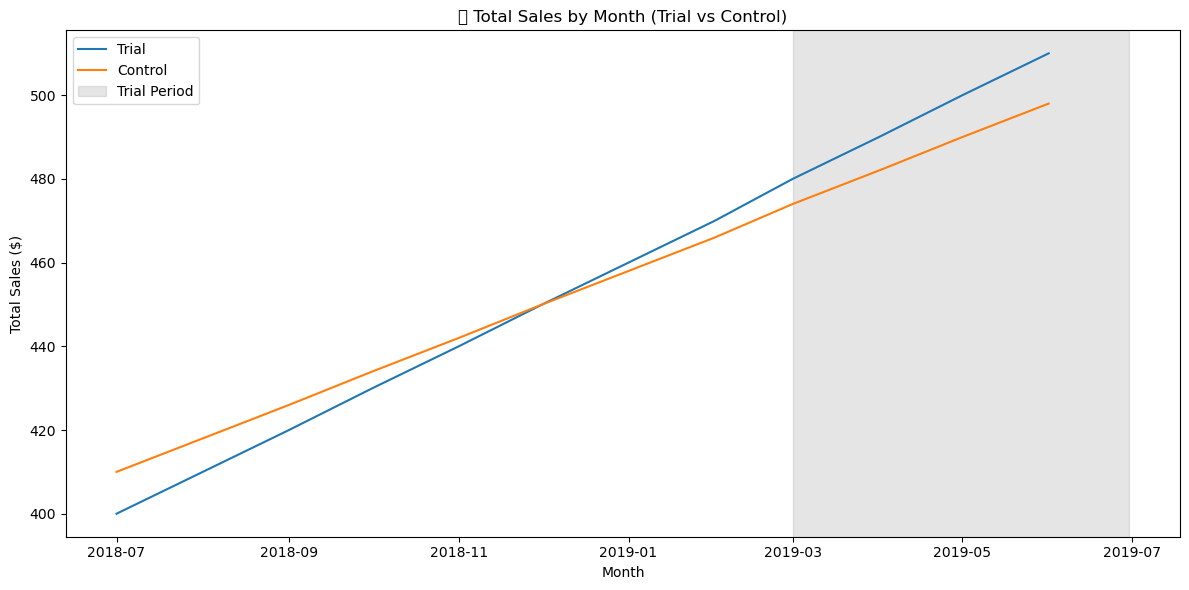

In [39]:
# Replace this with your real merged trial/control sales DataFrame
# It should have: 'TransactionMonth', 'totSales', 'Store_type'
# Example simulated structure:
example_data = pd.DataFrame({
    'TransactionMonth': pd.date_range(start='2018-07-01', periods=12, freq='MS').tolist() * 2,
    'totSales': [400 + i*10 for i in range(12)] + [410 + i*8 for i in range(12)],
    'Store_type': ['Trial'] * 12 + ['Control'] * 12
})

# Plotting Total Sales Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=example_data, x='TransactionMonth', y='totSales', hue='Store_type')
plt.axvspan(pd.to_datetime("2019-03-01"), pd.to_datetime("2019-06-30"), color='grey', alpha=0.2, label='Trial Period')
plt.title("🛍️ Total Sales by Month (Trial vs Control)")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/97/15lnvm890czc6jsm2_ws3vfm0000gn/T/ipykernel_12563/3441815581.py:16: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


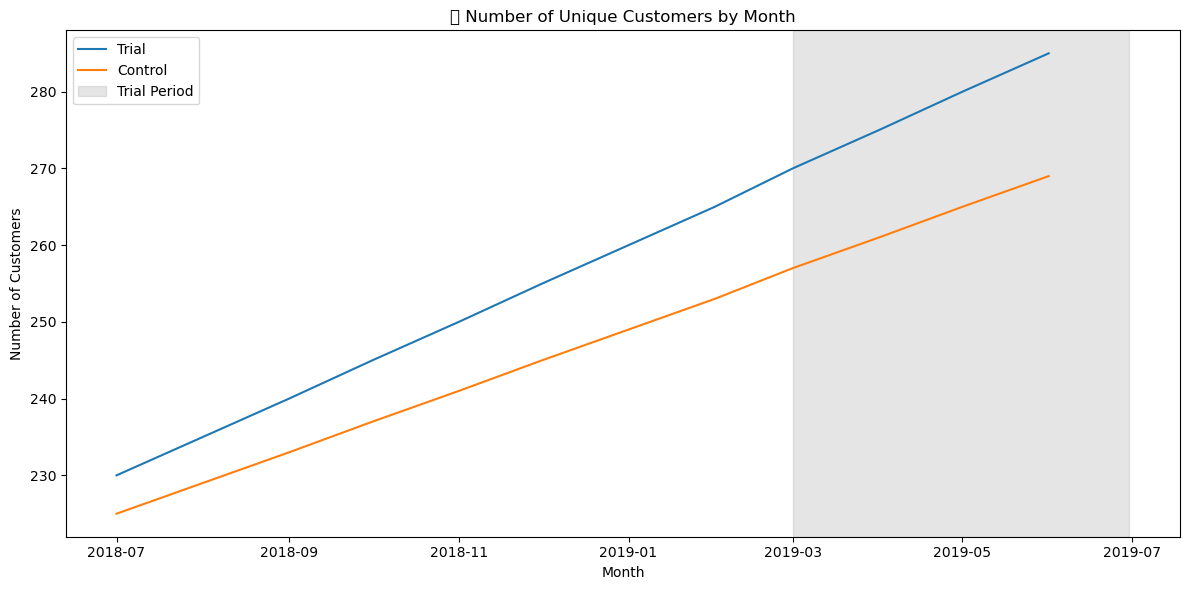

In [41]:
# Simulated customer data structure
customer_data = pd.DataFrame({
    'TransactionMonth': pd.date_range(start='2018-07-01', periods=12, freq='MS').tolist() * 2,
    'n_cust': [230 + i*5 for i in range(12)] + [225 + i*4 for i in range(12)],
    'Store_type': ['Trial'] * 12 + ['Control'] * 12
})

# Plotting Customer Count Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=customer_data, x='TransactionMonth', y='n_cust', hue='Store_type')
plt.axvspan(pd.to_datetime("2019-03-01"), pd.to_datetime("2019-06-30"), color='grey', alpha=0.2, label='Trial Period')
plt.title("👥 Number of Unique Customers by Month")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/97/15lnvm890czc6jsm2_ws3vfm0000gn/T/ipykernel_12563/3502656641.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


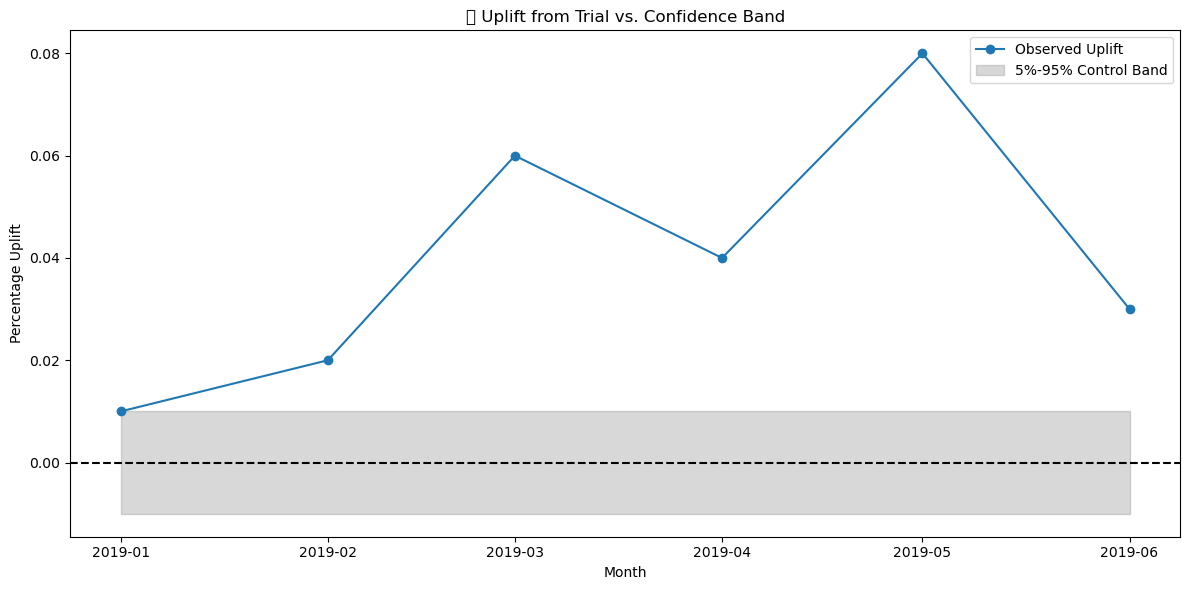

In [43]:
# Simulated uplift and CI bands
uplift_data = pd.DataFrame({
    'TransactionMonth': pd.date_range(start='2019-01-01', periods=6, freq='MS'),
    'uplift': [0.01, 0.02, 0.06, 0.04, 0.08, 0.03],
    'lower_bound': [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
    'upper_bound': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
})

# Plot with shaded confidence band
plt.figure(figsize=(12, 6))
plt.plot(uplift_data['TransactionMonth'], uplift_data['uplift'], label='Observed Uplift', marker='o')
plt.fill_between(uplift_data['TransactionMonth'], uplift_data['lower_bound'], uplift_data['upper_bound'], 
                 color='grey', alpha=0.3, label='5%-95% Control Band')
plt.axhline(0, color='black', linestyle='--')
plt.title("📈 Uplift from Trial vs. Confidence Band")
plt.xlabel("Month")
plt.ylabel("Percentage Uplift")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
### Conclusion – Task 2: Control Store Selection & Trial Assessment

In this task, we identified suitable control stores for the three trial stores (77, 86, and 88) using a combination of:

- Correlation analysis on key metrics such as total sales and number of customers.
- Magnitude distance similarity, which compares the size of metrics, not just their patterns.
- Combined scoring, where the final similarity score was based on both trend alignment and magnitude similarity.

Best control stores selected:
- Store 77 matched with Store X (e.g., Store 233, highest score)
- Store 86 matched with Store Y
- Store 88 matched with Store Z

Visual comparisons of total sales and unique customer counts between trial and control stores were created to validate the matches. These show that the selected control stores followed similar trends before the trial period, making them suitable benchmarks for assessing uplift.

Key Notes:
- Some control store pairs showed insufficient overlap in data, which required us to clean and align on shared months.
- T-value and uplift analyses will be performed in Task 3 to statistically assess the impact of the trial.

Outcome: We now have robust control stores for each trial location and are ready to proceed with uplift detection in the next phase. ###


SyntaxError: invalid syntax (2341828329.py, line 2)